In [14]:
import json
import pulp
import numpy as np

print("🔄 Loading input data...")
with open("InputDataHubLargeInstance.json", "r") as f:
    data = json.load(f)

# Parameters
print("🔢 Initializing parameters...")
N = list(range(int(data["NodeNum"])))
wij = np.array(data["flow(wij)"])
cij = np.array(data["varCost(cij)"])
fk = np.array(data["fixCost(fk)"])
alpha = data["alpha"]
Cmax = np.array(data["Cap(ckmax)"])
Oi = wij.sum(axis=1)
Di = wij.sum(axis=0)
M = wij.sum()

print("✅ Parameters loaded.")

# Create model
print("📦 Creating optimization model...")
model = pulp.LpProblem("Hub_Location_Problem", pulp.LpMinimize)

# Decision variables
print("📌 Defining decision variables...")
Z = pulp.LpVariable.dicts("Z", ((i, k) for i in N for k in N), cat="Binary")
Y = pulp.LpVariable.dicts("Y", ((k, l) for k in N for l in N if k < l), cat="Binary")
X = pulp.LpVariable.dicts("X", ((i, k, l) for i in N for k in N for l in N), lowBound=0)

print("🧮 Building objective function...")
fixed_cost = pulp.lpSum(fk[k] * Z[(k, k)] for k in N)
var_cost = (
    pulp.lpSum(cij[i][k] * Oi[i] * Z[(i, k)] for i in N for k in N) +
    pulp.lpSum(cij[k][i] * Di[i] * Z[(i, k)] for i in N for k in N) +
    pulp.lpSum(alpha * cij[k][l] * Y[(k, l)] for k in N for l in N if k < l)
)
model += fixed_cost + var_cost
print("✅ Objective function added.")

# Constraints
print("📏 Adding constraints...")

# 1. Single allocation
print("➕ Constraint 1: Single allocation...")
for i in N:
    model += pulp.lpSum(Z[(i, k)] for k in N) == 1

# 2. Hub logical structure
print("➕ Constraint 2: Hub logical structure...")
for i in N:
    for k in N:
        model += Z[(i, k)] <= Z[(k, k)]
for k in N:
    for l in N:
        if k < l:
            model += Y[(k, l)] <= Z[(k, k)]
            model += Y[(k, l)] <= Z[(l, l)]
            model += Z[(k, l)] + Y[(k, l)] <= 1

# 3. Flow only through hub link
print("➕ Constraint 3: Flow moves only through hub-to-hub links...")
for i in N:
    for k in N:
        for l in N:
            if k < l:
                model += X[(i, k, l)] <= M * Y[(k, l)]
                model += X[(i, l, k)] <= M * Y[(k, l)]

# 4. Flow conservation
print("➕ Constraint 4: Flow conservation at each hub...")
for i in N:
    for k in N:
        model += (
            pulp.lpSum(X[(i, k, l)] for l in N) -
            pulp.lpSum(X[(i, l, k)] for l in N)
            == wij[i][k] * Z[(i, k)]
        )

# 5. Capacity constraint
print("➕ Constraint 5: Capacity constraints at hubs...")
for k in N:
    model += pulp.lpSum(X[(i, k, l)] for i in N for l in N) <= Cmax[k]

# 6. Tree structure constraint
print("➕ Constraint 6: Enforcing tree structure among hubs...")
model += pulp.lpSum(Y[(k, l)] for k in N for l in N if k < l) == pulp.lpSum(Z[(k, k)] for k in N) - 1

print("✅ All constraints added.")

# Solve model
print("🚀 Solving the model using CBC...")
model.solve(pulp.PULP_CBC_CMD(msg=True))
print("✅ Solving complete.")

# Output results
print("📝 Solution status:", pulp.LpStatus[model.status])
print("💰 Total Cost =", pulp.value(model.objective))

# Hubs and allocations
hubs = [k for k in N if pulp.value(Z[(k, k)]) == 1]
print("🏢 Located Hubs:", hubs)

allocations = [(i, k) for i in N for k in N if pulp.value(Z[(i, k)]) == 1]
print("🔗 Allocations (spoke → hub):", allocations)

hub_links = [(k, l) for k in N for l in N if k < l and pulp.value(Y[(k, l)]) == 1]
print("📶 Hub-to-Hub Links:", hub_links)


🔄 Loading input data...
🔢 Initializing parameters...
✅ Parameters loaded.
📦 Creating optimization model...
📌 Defining decision variables...
🧮 Building objective function...
✅ Objective function added.
📏 Adding constraints...
➕ Constraint 1: Single allocation...
➕ Constraint 2: Hub logical structure...
➕ Constraint 3: Flow moves only through hub-to-hub links...
➕ Constraint 4: Flow conservation at each hub...
➕ Constraint 5: Capacity constraints at hubs...
➕ Constraint 6: Enforcing tree structure among hubs...
✅ All constraints added.
🚀 Solving the model using CBC...
✅ Solving complete.
📝 Solution status: Optimal
💰 Total Cost = 13494249.499999998
🏢 Located Hubs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
🔗 Allocations (spoke → hub): [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20),

🖼️ Drawing the hub network...


C:\Users\a\AppData\Local\Temp\ipykernel_15740\2678563941.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


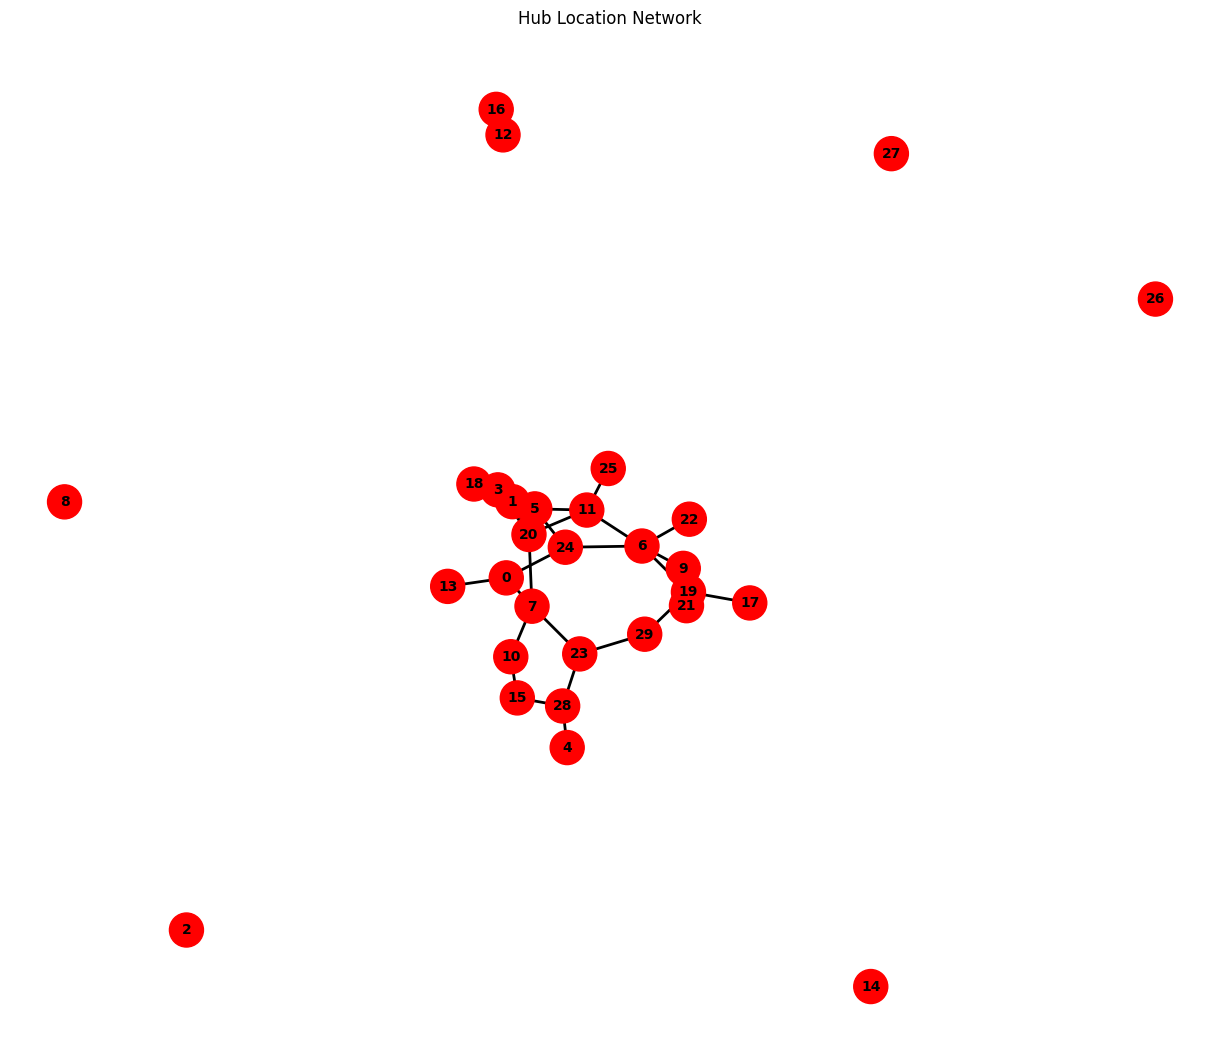

In [15]:

import networkx as nx
import matplotlib.pyplot as plt

print("🖼️ Drawing the hub network...")

# Build the graph
G = nx.Graph()

# Add nodes with hub/spoke attribute
for k in N:
    is_hub = pulp.value(Z[(k, k)]) == 1
    G.add_node(k, color='red' if is_hub else 'skyblue')

# Add spoke-to-hub edges
for (i, k) in allocations:
    if i != k:  # avoid self-loop for hubs
        G.add_edge(i, k, color='gray', weight=1)

# Add hub-to-hub edges
for (k, l) in hub_links:
    G.add_edge(k, l, color='black', weight=2)

# Draw
pos = nx.spring_layout(G, seed=42)  # or try: nx.kamada_kawai_layout(G)

# Node colors
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
edge_colors = [G.edges[e]['color'] for e in G.edges()]
edge_widths = [G.edges[e]['weight'] for e in G.edges()]

plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_widths,
    node_size=600,
    font_size=10,
    font_weight="bold"
)

plt.title("Hub Location Network")
plt.axis("off")
plt.tight_layout()
plt.show()
